In [1]:
import sys
import os

import albumentations
import pandas as pd
import numpy as np

import gc
from glob import glob
import pickle
import json
import subprocess
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, RepeatedStratifiedKFold


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, text, patheffects

from sklearn.model_selection import StratifiedKFold
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import seaborn as sns

import cv2
from tqdm import tqdm

import ast

In [2]:
# !pip install --no-index --find-links ../input/timmset2 tez
# !pip install --no-index --find-links ../input/timmset2 timm
!pip install --no-index --find-links ../input/timmset2 pytorch-lightning

Looking in links: ../input/timmset2


In [3]:
sys.path.append('../input/timmset2/pytorch-image-models')
import timm

import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule

In [4]:
!pip install --no-index --find-links ../input/yetanotherefficientdetpytorch webcolors

Looking in links: ../input/yetanotherefficientdetpytorch
Processing /kaggle/input/yetanotherefficientdetpytorch/webcolors-1.11.1-py3-none-any.whl


In [5]:
os.chdir('/kaggle/working')

In [6]:
sys.path.append('../input/yetanotherefficientdetpytorch')
sys.path.append('../input/yetanotherefficientdetpytorch/Yet-Another-EfficientDet-Pytorch')
# os.chdir('./yetanotherefficientdetpytorch/Yet-Another-EfficientDet-Pytorch')
# sys.path.append('.')
# from backbone import EfficientDetBackbon
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, STANDARD_COLORS, standard_to_bgr, get_index_label, plot_one_box
from torch.backends import cudnn
import time

In [7]:
from efficientdet.model import BiFPN, Regressor, Classifier, EfficientNet
from efficientdet.utils import Anchors


class EfficientDetBackbone(nn.Module):
    def __init__(self, num_classes=80, compound_coef=0, load_weights=False, **kwargs):
        super(EfficientDetBackbone, self).__init__()
        self.compound_coef = compound_coef

        self.backbone_compound_coef = [0, 1, 2, 3, 4, 5, 6, 6, 7]
        self.fpn_num_filters = [64, 88, 112, 160, 224, 288, 384, 384, 384]
        self.fpn_cell_repeats = [3, 4, 5, 6, 7, 7, 8, 8, 8]
        self.input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
        self.box_class_repeats = [3, 3, 3, 4, 4, 4, 5, 5, 5]
        self.pyramid_levels = [5, 5, 5, 5, 5, 5, 5, 5, 6]
        self.anchor_scale = [4., 4., 4., 4., 4., 4., 4., 5., 4.]
        self.aspect_ratios = kwargs.get('ratios', [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)])
        self.num_scales = len(kwargs.get('scales', [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]))
        conv_channel_coef = {
            # the channels of P3/P4/P5.
            0: [40, 112, 320],
            1: [40, 112, 320],
            2: [48, 120, 352],
            3: [48, 136, 384],
            4: [56, 160, 448],
            5: [64, 176, 512],
            6: [72, 200, 576],
            7: [72, 200, 576],
            8: [80, 224, 640],
        }

        num_anchors = len(self.aspect_ratios) * self.num_scales

        self.bifpn = nn.Sequential(
            *[BiFPN(self.fpn_num_filters[self.compound_coef],
                    conv_channel_coef[compound_coef],
                    True if _ == 0 else False,
                    attention=True if compound_coef < 6 else False,
                    use_p8=compound_coef > 7)
              for _ in range(self.fpn_cell_repeats[compound_coef])])

        self.num_classes = num_classes
        self.regressor = Regressor(in_channels=self.fpn_num_filters[self.compound_coef], num_anchors=num_anchors,
                                   num_layers=self.box_class_repeats[self.compound_coef],
                                   pyramid_levels=self.pyramid_levels[self.compound_coef])
        self.classifier = Classifier(in_channels=self.fpn_num_filters[self.compound_coef], num_anchors=num_anchors,
                                     num_classes=num_classes,
                                     num_layers=self.box_class_repeats[self.compound_coef],
                                     pyramid_levels=self.pyramid_levels[self.compound_coef])

        self.anchors = Anchors(anchor_scale=self.anchor_scale[compound_coef],
                               pyramid_levels=(torch.arange(self.pyramid_levels[self.compound_coef]) + 3).tolist(),
                               **kwargs)

        self.backbone_net = EfficientNet(self.backbone_compound_coef[compound_coef], load_weights)

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def forward(self, inputs):
        max_size = inputs.shape[-1]

        _, p3, p4, p5 = self.backbone_net(inputs)

        features = (p3, p4, p5)
        features = self.bifpn(features)

        regression = self.regressor(features)
        classification = self.classifier(features)
        anchors = self.anchors(inputs, inputs.dtype)

        return features, regression, classification, anchors

    def init_backbone(self, path):
        state_dict = torch.load(path)
        try:
            ret = self.load_state_dict(state_dict, strict=False)
            print(ret)
        except RuntimeError as e:
            print('Ignoring ' + str(e) + '"')

In [8]:
!pip install --no-index --find-links ../input/monaiset monai
import monai.transforms as mT

Looking in links: ../input/monaiset
Processing /kaggle/input/monaiset/monai-0.8.0-202111251823-py3-none-any.whl


In [9]:
global IMG_SIZE, BATCH_SIZE, MODEL_NAME
# Constants
IMG_SIZE = 224
CHANNELS = 3
Q = 30
SEED = 2051

# BATCH_SIZE = 8
BATCH_SIZE = 32

REPETE_NUMBER = 3
LR = 0.000005
WD = 0.0000005
EPOCHS = 100
EARRY_STOP = 3


MODEL_NAME = "model"

OPT_NAME = 'torch.optim.AdamW'
OPT_PARAMS = {'lr': 1e-5}

SCH_NAME = 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'
SCH_PARAMS = {
  'T_0': 20,
  'eta_min': 1e-4,
  }
TRAINER = {
  'gpus': 1,
  'accumulate_grad_batches': 1,
  'progress_bar_refresh_rate': 1,
  'fast_dev_run': False,
  'num_sanity_val_steps': 0,
  'resume_from_checkpoint': None,
  }
TRN_LOADER = {
  'batch_size': BATCH_SIZE,
  'shuffle': True,
  'num_workers': 4,
  'pin_memory': False,
  'drop_last': True,
  }
VAL_LOADER = {
  'batch_size': BATCH_SIZE,
  'shuffle': False,
  'num_workers': 4,
  'pin_memory': False,
  'drop_last': False
  }
LOSS = 'nn.BCEWithLogitsLoss'

GRADCAM_BATCH_SIZE = 16


MD_NAME = 'nb019-v001'

SVR_PATH = '.'
# SVR_PATH = '../input/nb019-svr'
SVR_RATIO = 0.4

In [10]:
# Check Val
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_result(folder_names):
    val_result = pd.DataFrame()

    model_names = []
    model_vals = []

    for folder_name in folder_names:
        paths = glob(f'{folder_name}/version_*')
        for path in paths:
            print(path)
            e_path = glob(f'{path}/events*')[0]
            event_acc = EventAccumulator(path, size_guidance={'scalars': 0})
            event_acc.Reload()

            scalars = {}
            for tag in event_acc.Tags()['scalars']:
                events = event_acc.Scalars(tag)
                scalars[tag] = [event.value for event in events]

            model_names.append(path)
            model_vals.append(min(scalars['val_loss']))

    val_result['name'] = model_names
    val_result['val'] = model_vals
    return val_result

In [11]:
# folder_names = [
#     '../input/nb021nc-v001',
#     '../input/nb021nc-v002',
#     '../input/nb021nc-v004',
    
# ]
# result_normal = get_result(folder_names)
# # result_normal = result_normal.sort_values('val')
# # result_normal = result_normal[:6]

# # Bad
# result_normal = result_normal.drop(2)
# result_normal = result_normal.drop(3)
# result_normal = result_normal.drop(10)
# result_normal = result_normal.drop(13)
# result_normal = result_normal.drop(14)

# # Little Bad
# result_normal = result_normal.drop(1)
# result_normal = result_normal.drop(7)
# result_normal = result_normal.drop(12)

# result_normal

In [12]:
folder_names = [
#     '../input/nb021nc-v001',
#     '../input/nb021nc-v002',
    '../input/nb021nc-v004',
    '../input/nb021nc-v006',
    
]
result_normal = get_result(folder_names)
# result_normal = result_normal.sort_values('val')
# result_normal = result_normal[:6]

result_normal

../input/nb021nc-v004/version_0
../input/nb021nc-v004/version_2
../input/nb021nc-v004/version_1
../input/nb021nc-v004/version_4
../input/nb021nc-v004/version_3
../input/nb021nc-v004/version_5
../input/nb021nc-v006/version_0
../input/nb021nc-v006/version_2
../input/nb021nc-v006/version_1
../input/nb021nc-v006/version_4
../input/nb021nc-v006/version_3
../input/nb021nc-v006/version_5


,name,val
0,../input/nb021nc-v004/version_0,17.595892
1,../input/nb021nc-v004/version_2,17.944340
2,../input/nb021nc-v004/version_1,17.143229
3,../input/nb021nc-v004/version_4,17.670881
4,../input/nb021nc-v004/version_3,17.908113
5,../input/nb021nc-v004/version_5,17.877029
6,../input/nb021nc-v006/version_0,17.596260
7,../input/nb021nc-v006/version_2,17.794207
8,../input/nb021nc-v006/version_1,18.303127
9,../input/nb021nc-v006/version_4,17.513140


In [13]:
# result_normal = pd.DataFrame()

# model_names = []
# model_vals = []

# paths = [
#     '../input/nb019-v005/version_3',
#     '../input/nb019-v016/version_3',
#     '../input/nb021-v013/version_0',
#     '../input/nb021-v013/version_1',
#     '../input/nb021-v013/version_4',
#     '../input/nb021-v013/version_5',
# ]
# for path in paths:
#     print(path)
#     e_path = glob(f'{path}/events*')[0]
#     event_acc = EventAccumulator(path, size_guidance={'scalars': 0})
#     event_acc.Reload()

#     scalars = {}
#     for tag in event_acc.Tags()['scalars']:
#         events = event_acc.Scalars(tag)
#         scalars[tag] = [event.value for event in events]

#     model_names.append(path)
#     model_vals.append(min(scalars['val_loss']))

# result_normal['name'] = model_names
# result_normal['val'] = model_vals
# result_normal


In [14]:
# result_normal['nb'] = result_normal['name'].str.split('/', expand=True)[2]
# result_normal.groupby('nb')['val'].describe()

In [15]:
folder_names = [
#     '../input/nb021nc-v005',
    '../input/nb021nc-v007',
]
result_xcit = get_result(folder_names)
result_xcit = result_xcit.sort_values('val')
# result_xcit = result_xcit[:4]
# result_xcit = result_xcit.drop(0)
result_xcit

../input/nb021nc-v007/version_0
../input/nb021nc-v007/version_2
../input/nb021nc-v007/version_1
../input/nb021nc-v007/version_4
../input/nb021nc-v007/version_3


,name,val
0,../input/nb021nc-v007/version_0,17.470871
1,../input/nb021nc-v007/version_2,17.661041
4,../input/nb021nc-v007/version_3,17.698793
3,../input/nb021nc-v007/version_4,17.806625
2,../input/nb021nc-v007/version_1,17.905058


In [16]:
folder_names = [  
    '../input/nb021nc-v003',
]
result_nfnet = get_result(folder_names)
# result_nfnet = result_nfnet.sort_values('val')
# result_nfnet = result_nfnet[:3]
# result_nfnet = result_nfnet.drop(0)
result_nfnet

../input/nb021nc-v003/version_0
../input/nb021nc-v003/version_4


,name,val
0,../input/nb021nc-v003/version_0,17.661165
1,../input/nb021nc-v003/version_4,17.343513


In [17]:
print('normal')
print(result_normal['val'].describe())
print('\nxcit')
print(result_xcit['val'].describe())
print('\nnfnet')
print(result_nfnet['val'].describe())

normal
count    12.000000
mean     17.677794
std       0.327640
min      17.143229
25%      17.575204
50%      17.657114
75%      17.884800
max      18.303127
Name: val, dtype: float64

xcit
count     5.000000
mean     17.708478
std       0.163614
min      17.470871
25%      17.661041
50%      17.698793
75%      17.806625
max      17.905058
Name: val, dtype: float64

nfnet
count     2.000000
mean     17.502339
std       0.224614
min      17.343513
25%      17.422926
50%      17.502339
75%      17.581752
max      17.661165
Name: val, dtype: float64


../input/nb021nc-v004/version_0


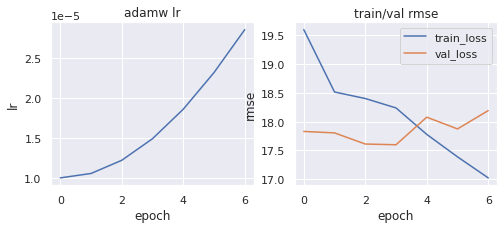

best_val_loss 17.59589195251465

../input/nb021nc-v004/version_2


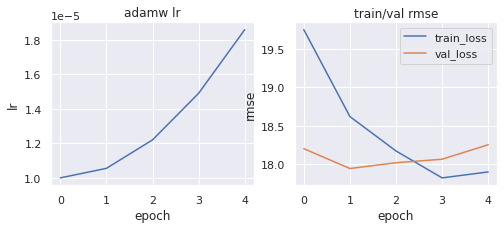

best_val_loss 17.944339752197266

../input/nb021nc-v004/version_1


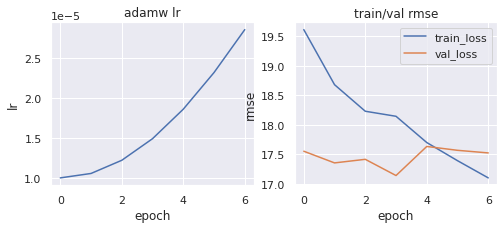

best_val_loss 17.14322853088379

../input/nb021nc-v004/version_4


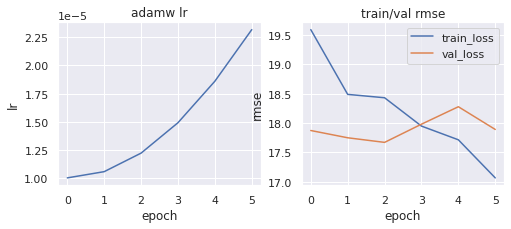

best_val_loss 17.670881271362305

../input/nb021nc-v004/version_3


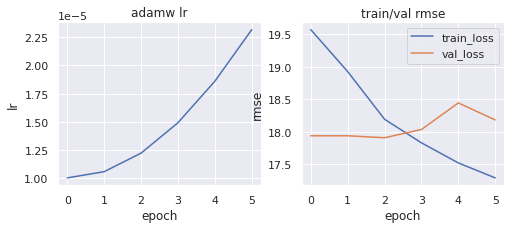

best_val_loss 17.908113479614258

../input/nb021nc-v004/version_5


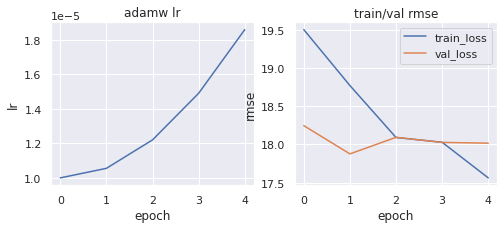

best_val_loss 17.877029418945312

../input/nb021nc-v006/version_0


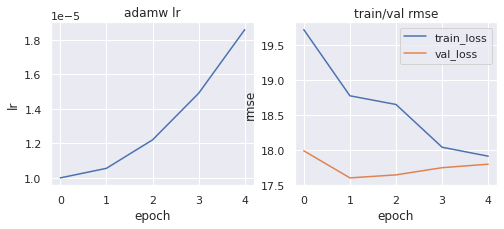

best_val_loss 17.59626007080078

../input/nb021nc-v006/version_2


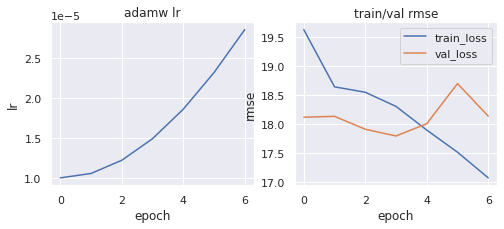

best_val_loss 17.794206619262695

../input/nb021nc-v006/version_1


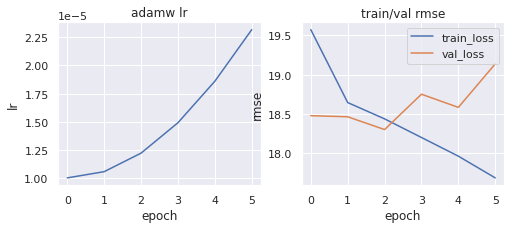

best_val_loss 18.30312728881836

../input/nb021nc-v006/version_4


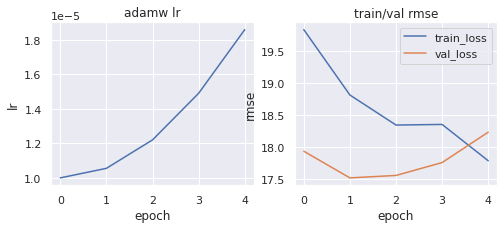

best_val_loss 17.513139724731445

../input/nb021nc-v006/version_3


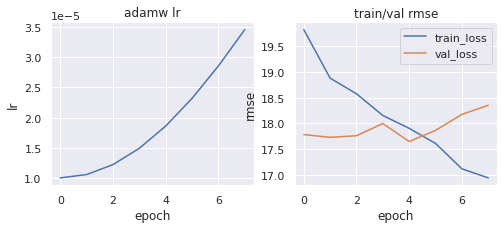

best_val_loss 17.643346786499023

../input/nb021nc-v006/version_5


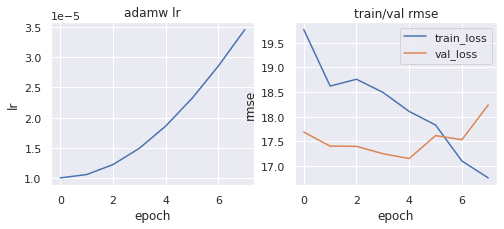

best_val_loss 17.143957138061523

../input/nb021nc-v007/version_0


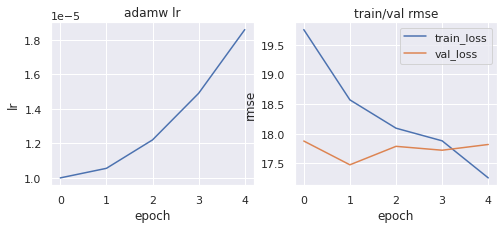

best_val_loss 17.470870971679688

../input/nb021nc-v007/version_2


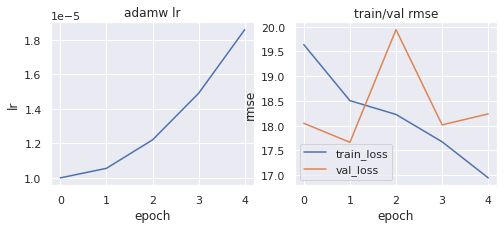

best_val_loss 17.661041259765625

../input/nb021nc-v007/version_3


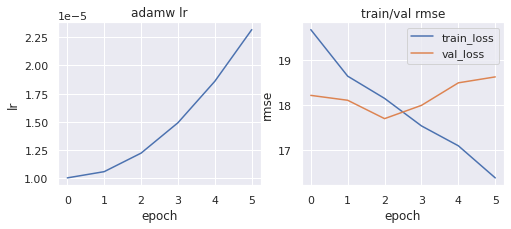

best_val_loss 17.698793411254883

../input/nb021nc-v007/version_4


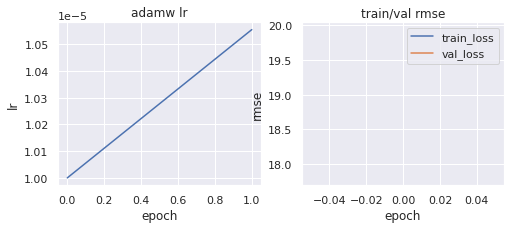

best_val_loss 17.806625366210938

../input/nb021nc-v007/version_1


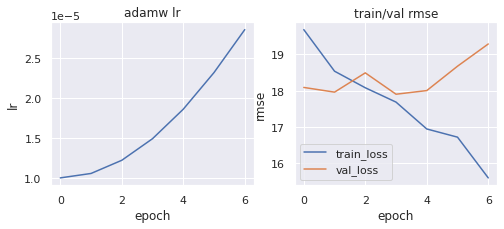

best_val_loss 17.905057907104492

../input/nb021nc-v003/version_0


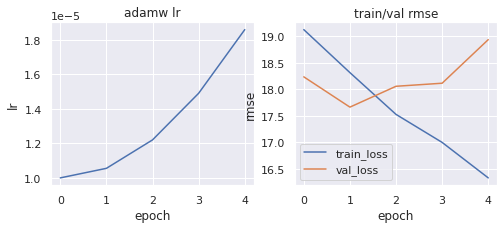

best_val_loss 17.661165237426758

../input/nb021nc-v003/version_4


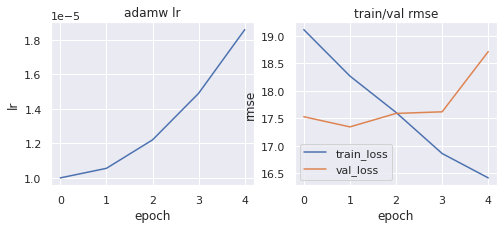

best_val_loss 17.34351348876953



In [18]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns

paths = result_normal['name'].tolist()
paths.extend(result_xcit['name'].tolist())
paths.extend(result_nfnet['name'].tolist())

for path in paths:
    print(path)
    e_path = glob(f'{path}/events*')[0]
    event_acc = EventAccumulator(path + '/', size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    sns.set()

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(scalars['lr-AdamW'])), scalars['lr-AdamW'])
    plt.xlabel('epoch')
    plt.ylabel('lr')
    plt.title('adamw lr')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(scalars['train_loss'])), scalars['train_loss'], label='train_loss')
    plt.plot(range(len(scalars['val_loss'])), scalars['val_loss'], label='val_loss')
    plt.legend()
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.title('train/val rmse')
    plt.show()
    print('best_val_loss', min(scalars['val_loss']))
    print()

In [19]:
def get_transform_value(train, field, width, height):
    classes = np.array(field['classes'])
    animal_indexes = np.where((classes == 16) | (classes == 17))[0]
    minimum_crop = min(width, height)
    if len(animal_indexes) == 0:
        return {'cx': width / 2, 'cy': height / 2, 'ms': minimum_crop, 'msx': minimum_crop, 'msy': minimum_crop}

    box = np.array(field['boxes']).astype(np.int)
    box = box[animal_indexes]

    width_x = (box[:, 2].max() - box[:, 0].min())
    width_y = (box[:, 3].max() - box[:, 1].min())
 
    center_x = (box[:, 0].min()) + (width_x / 2)
    center_y = (box[:, 1].min()) + (width_y / 2)

    min_size = max(width_x, width_y)
    min_size = np.clip(min_size, 100, minimum_crop)
    min_size_x = np.clip(width_x, 100, width)
    min_size_y = np.clip(width_y, 100, height)

    return {'cx': center_x, 'cy': center_y, 'ms': min_size, 'msx': min_size_x, 'msy': min_size_y}


In [20]:
def str_to_list(colum_str):
    string = colum_str.split("array(")[1]
    string = string.split(']')[0:-1]
    string = ']'.join(string)
    string += ']'
    return ast.literal_eval(string)
    
def fields_to_dict(field_text):
    field = field_text
    field = field[1:-1]

    field = field.split('),')

    boxes = field[1]
    score = field[0]
    classes = field[2]

    boxes = str_to_list(boxes)
    score = str_to_list(score)
    classes = str_to_list(classes)
    return {'boxes': boxes, 'score': score, 'classes': classes}

def set_boxes_info(df):
    df['cx'] = 0
    df['cy'] = 0
    df['ms'] = 0
    df['msx'] = 0
    df['msy'] = 0
    for index in df.index:
        min_ms = min([df.loc[index, 'width'], df.loc[index, 'height']])
        result = get_transform_value(False,df.loc[index, 'fields'], df.loc[index, 'width'], df.loc[index, 'height'])
        cx = result['cx']
        cy = result['cy']
        ms = result['ms']
        msx = result['msx']
        msy = result['msy']

        df.loc[index, ['cx', 'cy', 'ms', 'msx', 'msy']] = [cx, cy, ms, msx, msy]

In [21]:
# CPU or GPU
# for colab
DATA_DIR = '../input/petfinder-pawpularity-score'

# # Use only GPU
IMG_PATH = DATA_DIR

In [22]:
test_df=pd.read_csv(f'{DATA_DIR}/test.csv')
test_df['image_path'] = f'{IMG_PATH}/test/' + test_df['Id'] + '.jpg'

# Define Model

In [23]:
dense_features = [
    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur',
    'Persons', 'Cats', 'Dogs', 'Animals',
]

In [24]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB


def get_default_transforms():
    transform = {
        "train": T.Compose([
          # T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
          T.RandomHorizontalFlip(),
          T.RandomVerticalFlip(),
          T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

          T.ConvertImageDtype(torch.float),
          T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ]),
        "val": T.Compose([
          T.RandomHorizontalFlip(),

          T.ConvertImageDtype(torch.float),
          T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ]),
    }
    return transform

In [25]:
class PetfinderDataset(Dataset):
    def __init__(self, df, train=True):
        self._X = df["Id"].values
        self._y = None
        self._train = train
        self._image_path = df["image_path"].values
        # self._dense_features = df[dense_features].values

        self._fields = df['fields'].values
        self._cats = df['Cats'].values
        self._dogs = df['Dogs'].values
        self._animalss = df['Animals'].values

        self._width = df['width'].values
        self._height = df['height'].values

        self._cx = df['cx'].values
        self._cy = df['cy'].values
        
        self._ms = df['ms'].values
        self._msx = df['msx'].values
        self._msy = df['msy'].values

        if "Pawpularity" in df.keys():
            self._y = df["Pawpularity"].values

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._image_path[idx]
        image = read_image(image_path)

        # Procese of get box
        field = self._fields[idx]
        width = self._width[idx]
        height = self._height[idx]

        image_size = min(width,height)

        cx = self._cx[idx]
        cy = self._cy[idx]
        ms = self._ms[idx]
        # Set msx and msy as big as possible, then crop
        msx = self._msx[idx]
        msy = self._msy[idx]
     
        if self._train:
            transfomer = mT.Compose([          
                T.RandomRotation(degrees=(-45, 45)),
                T.RandomPerspective(distortion_scale=0.3, p=0.4),

                mT.SpatialCrop(roi_center=[cy, cx], roi_size=[msy, msx]),
                mT.Resize([IMG_SIZE, IMG_SIZE]),
            ])
        else:            
            # TTA
            if self._animalss[idx] > 1:
                if torch.rand(1)[0] > 0.7:
                    # Add columns by each crop
                    classes = np.array(field['classes'])
                    animal_indexes = np.where((classes == 16) | (classes == 17))[0]
                    
                    box = np.array(field['boxes']).astype(np.int)
                    box = box[animal_indexes]
                    animal_i = torch.randint(0, len(box), (1,))[0]
                    
                    msx = (box[animal_i, 2] - box[animal_i, 0])
                    msy = (box[animal_i, 3] - box[animal_i, 1])

                    cx = (box[animal_i, 0]) + (msx / 2)
                    cy = (box[animal_i, 1]) + (msy / 2)
                    
                    ms = max(msx, msy)
            
            swift_rand = torch.rand(3)
            
            ms += (ms * (swift_rand[0] - 0.3) * 0.1)
            msx += (msx * (swift_rand[0] - 0.3) * 0.1)
            msy += (msy * (swift_rand[0] - 0.3) * 0.1)
            
            cx += (msx * (swift_rand[1] - 0.5) * 0.1)
            cy += (msy * (swift_rand[2] - 0.5) * 0.1)
            cx = np.clip(cx, 0, width)
            cy = np.clip(cy, 0, height)
            
            ms = np.clip(ms, 100, image_size)
            msx = ms
            msy = ms  

            transfomer = mT.Compose([
                mT.SpatialCrop(roi_center=[cy, cx], roi_size=[msy, msx]),
                mT.Resize([IMG_SIZE, IMG_SIZE]),
            ])
          
        try:
            image = transfomer(image)
        except:
            print("error")
            transfomer = mT.Compose([
                mT.RandSpatialCrop(ms*0.99),
                mT.Resize([IMG_SIZE, IMG_SIZE]),
            ])
            image = transfomer(image)

        if self._y is not None:
            label = self._y[idx]
            return {"image": image, "label": label}
        return {"image": image}

class PetfinderDataModule(LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
    ):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df

    def __create_dataset(self, train=True):
        return (
          PetfinderDataset(self._train_df, train)  if train else PetfinderDataset(self._val_df, train)
        )

    def train_dataloader(self):
        dataset = self.__create_dataset(True)
        return DataLoader(dataset, **TRN_LOADER)

    def val_dataloader(self):
        dataset = self.__create_dataset(False)
        return DataLoader(dataset, **VAL_LOADER)


In [26]:
class PawpularModel(pl.LightningModule):
    def __init__(self, model_name, model_type):
        super().__init__()
        self.__build_model(model_name, model_type)
        self._criterion = eval(LOSS)()
        self.transform = get_default_transforms()

    def __build_model(self, model_name, model_type):
        if model_type=='nb019':
            self.base = timm.create_model(
                model_name, pretrained=False, num_classes=0, in_chans=3
            )
            num_features = self.base.num_features
            self.fc = nn.Sequential(
                nn.Dropout(0.1),
                nn.LazyLinear(1)
            )
        elif model_type=='onlyresize':
            self.base = timm.create_model(
                model_name, pretrained=False, num_classes=0, in_chans=3
            )
            num_features = self.base.num_features
            self.fc = nn.Sequential(
                nn.Dropout(0.1),
                nn.LazyLinear(1)
            )
            
        elif model_type=='ensemble':
            self.base = timm.create_model(
                model_name, pretrained=False, num_classes=0, in_chans=3
            )
            num_features = self.base.num_features
            self.fc = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(num_features, 128),
                nn.Softmax(128, 10),
            )

    def forward(self, image):
        f = self.base(image)
        out = self.fc(f)
        return out
    def training_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'train')
        return {'loss': loss, 'pred': pred, 'labels': labels}
        
    def validation_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'val')
        return {'pred': pred, 'labels': labels}
    
    def test_step(self, batch, batch_idx):
        # For transform, set mode val
        loss, pred, labels = self.__share_step(batch, 'val')
        return {'pred': pred, 'labels': labels}
    
    def __share_step(self, batch, mode):
        images, labels = batch['image'], batch['label']
        labels = labels / 100.0
        images = self.transform[mode](images)
        
        if torch.rand(1)[0] < 0.5 and mode == 'train':
            mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
            logits = self.forward(mix_images).squeeze(1)
            loss = self._criterion(logits, target_a) * lam + \
                (1 - lam) * self._criterion(logits, target_b)
        else:
            logits = self.forward(images).squeeze(1)
            loss = self._criterion(logits, labels)
        
        pred = logits.sigmoid().detach().cpu() * 100.
        labels = labels.detach().cpu() * 100.
        return loss, pred, labels
        
    def training_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'val')
        
    def test_epoch_end(self, outputs):
        result = self.__share_epoch_end(outputs, 'test')
        
    def __share_epoch_end(self, outputs, mode):
        preds = []
        labels = []
        for out in outputs:
            pred, label = out['pred'], out['labels']
            preds.append(pred)
            labels.append(label)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        metrics = torch.sqrt(((labels - preds) ** 2).mean())
        self.log(f'{mode}_loss', metrics)
        
    def predict_step(self, batch, batch_idx):
        # For transform, set mode val
        images = self.transform['val'](batch['image'])
        logits = self.forward(images)  .squeeze(1)   
        pred = logits.sigmoid().detach().cpu() * 100.
        return {'pred': pred}
    def on_predict_epoch_end(self, outputs):
        preds = []
        for out in outputs[0]:
            preds.append(out['pred'])
        result = torch.cat(preds)

    def configure_optimizers(self):
        optimizer = eval(OPT_NAME)(
          self.parameters(), **OPT_PARAMS
        )
        scheduler = eval(SCH_NAME)(
          optimizer,
          **SCH_PARAMS
        )
        return [optimizer], [scheduler]

    

In [27]:
trainer = pl.Trainer(
  max_epochs= EPOCHS,
  callbacks=[],
  **TRAINER
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


In [28]:
def predict_paths(model_name, model_type, paths, df):
    versions_paths = []
    versions_preds = []
    versions_clf_preds = []
    
    datamodule = PetfinderDataModule(df, df)
    if model_type ==  'onlyresize':
        datamodule = OnlyresizeDataModule(df, df)
    val_dl = datamodule.val_dataloader()
    
    features = df[dense_features].values
    
    model = PawpularModel(model_name, model_type)
    model = model.cuda().eval()
    
    for path in paths:
        model.load_state_dict(torch.load(f'{path}/checkpoints/best_loss.ckpt')['state_dict'])
        model = model.cuda().eval()
        
        s_preds = trainer.predict(model, val_dl)
        preds = np.array([])
        for row in s_preds:
            preds = np.concatenate((preds, row['pred']), axis=0)
        train_features = np.concatenate((preds[:, np.newaxis], features), axis=1)

        # For no svr
        clf_preds = [0]
    
        versions_paths.append(path)
        versions_preds.append(preds)
        versions_clf_preds.append(clf_preds)
    return {'paths': versions_paths, 'preds': np.float32(versions_preds), 'clf_preds': np.float32(versions_clf_preds)}

In [29]:
def normal_predict(df):
    model_name = 'swin_large_patch4_window7_224'
    model_type = 'nb019'
    
    paths = result_normal['name']

    IMG_SIZE = 224
    BATCH_SIZE = 32
    
    return predict_paths(model_name, model_type, paths, df)

In [30]:
def xcit_predict(df):
    model_name = 'xcit_large_24_p8_224_dist'
    model_type = 'nb019'
    
    paths = result_xcit['name']
    
    IMG_SIZE = 384
    BATCH_SIZE = 16
    return predict_paths(model_name, model_type, paths, df)

In [31]:
def nfnet_predict(df):
    model_name = 'dm_nfnet_f1'
    model_type = 'nb019'
    
    paths = result_nfnet['name']
    
    IMG_SIZE = 320
    BATCH_SIZE = 16
    return predict_paths(model_name, model_type, paths, df)

In [32]:
def nfnet2_predict(df):
    model_name = 'dm_nfnet_f2'
    model_type = 'nb019'
    
    paths = ["../input/nb021nc-v008"]
    
    IMG_SIZE = 352
    BATCH_SIZE = 16
    return predict_paths(model_name, model_type, paths, df)

In [33]:
def multiple_ratio(preds):
    y_pred = np.zeros(len(preds[0]))
    best_ratios = np.array([1.0/len(preds) for i in range(len(preds))])

    for i, ratio in enumerate(best_ratios):
        y_pred += (preds[i] * ratio)
    return y_pred

In [34]:
compound_coef = 8
force_input_size = None  # set None to use default size
# img_path = train_df.loc[14, 'image_path']

# replace this part with your project's anchor config
anchor_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
            'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie',
            'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
            'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv',
            'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
            'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush']


color_list = standard_to_bgr(STANDARD_COLORS)
# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size

detect_model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             ratios=anchor_ratios, scales=anchor_scales)
detect_model.load_state_dict(torch.load(f'../input/yetanotherefficientdetpytorch/weights/efficientdet-d{compound_coef}.pth', map_location='cuda'))
detect_model.requires_grad_(False)
detect_model.eval()

if use_cuda:
    detect_model = detect_model.cuda()
if use_float16:
    detect_model = detect_model.half()

regressBoxes = BBoxTransform()
clipBoxes = ClipBoxes()

In [35]:
def add_hwf(df):
    # Object detec to train_confirm
    df['width'] = 0
    df['height'] = 0
    df['fields'] = ''
    
    df['Persons'] = 0
    df['Cats'] = 0
    df['Dogs'] = 0
    df['Animals'] = 0

    for index in tqdm(df.index):
        img_path = df.loc[index, 'image_path']
        ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)
        df.loc[index, 'width'] = framed_metas[0][2]
        df.loc[index, 'height'] = framed_metas[0][3]
    

        if use_cuda:
            x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
        else:
            x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

        x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

        features, regression, classification, anchors = detect_model(x)

        out = postprocess(x,
            anchors, regression, classification,
            regressBoxes, clipBoxes,
            threshold, iou_threshold)
        out = invert_affine(framed_metas, out)[0]
        out['boxes'] = out.pop('rois')
        out['classes'] = out.pop('class_ids')
        out['scores'] = out['scores']

        df.loc[index, 'fields'] = str(out)

        df.loc[index, 'Persons'] = out['classes'].tolist().count(0)
        df.loc[index, 'Cats'] = out['classes'].tolist().count(16)
        df.loc[index, 'Dogs'] = out['classes'].tolist().count(17)
        df.loc[index, 'Animals'] = df.loc[index, 'Cats'] + df.loc[index, 'Dogs']

# CV Using Confirm

In [36]:
# train_df=pd.read_csv(f'../input/petfinder2-detected-info/train.csv')
# train_df['image_path'] = f'{IMG_PATH}/train/' + train_df['Id'] + '.jpg'
# train_df['fields'] = train_df['fields'].apply(fields_to_dict)
# set_boxes_info(train_df)
# train_df['Animals'] = train_df['Cats'] + train_df['Dogs']

# confirm_index = []
# with open('../input/val-index/val_index.pkl', 'rb') as web:
#     confirm_index = pickle.load(web)
# train_confirm = train_df.iloc[confirm_index]
# train_df = train_df.drop(confirm_index)

In [37]:
# train_confirm['Pawpularity'].describe()

In [38]:
# %%time
# normal_result = normal_predict(train_confirm)

In [39]:
# for i in range(len(normal_result['preds'])):
#     apply_index = [False for i in range(len(normal_result['preds']))]
#     apply_index[i] = True

#     preds = multiple_ratio(normal_result['preds'][apply_index])
#     # preds = multiple_ratio(normal_preds_array)
#     train_confirm['preds'] = preds
#     print(normal_result['paths'][i])
#     print(preds.mean(), preds.std(), np.sqrt(mean_squared_error(train_confirm['Pawpularity'], preds)))

#     # Cats CV
#     specific_data = train_confirm[(train_confirm['Cats']) > 0]
#     print(len(specific_data))
#     print(np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))

#     # Dogs CV
#     specific_data = train_confirm[(train_confirm['Dogs']) > 0]
#     print(len(specific_data))
#     print(np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))

In [40]:
# preds = multiple_ratio(normal_result['preds'])
# train_confirm['preds'] = preds

In [41]:
# print(preds.mean(), preds.std(), np.sqrt(mean_squared_error(train_confirm['Pawpularity'], preds)))
# # Cats CV
# specific_data = train_confirm[(train_confirm['Cats']) > 0]
# print("Cats", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))
# # Dogs CV
# specific_data = train_confirm[(train_confirm['Dogs']) > 0]
# print("Dogs", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))

# print("Animals")
# for i in range(8):
#     specific_data = train_confirm[train_confirm['Animals'] == i]
#     print(i, len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))

In [42]:
# one_animal = train_confirm[train_confirm['Animals']==1]

# specific_data = one_animal[one_animal['width'] > one_animal['height']]
# print("width > height", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))
# print()

# specific_data = one_animal[one_animal['width'] < one_animal['height']]
# print("width < height", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))
# print()

# specific_data = one_animal[one_animal['width'] > (one_animal['height'] * 1.3)]
# print("width> height * 1.3 ", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))
# print()
# specific_data = one_animal[(one_animal['width'] * 1.3) < one_animal['height']]
# print("width * 1.3 < height", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))
# print()

# specific_data = one_animal[one_animal['width'] > (one_animal['height'] * 1.5)]
# print("width> height * 1.5 ", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))
# print()
# specific_data = one_animal[(one_animal['width'] * 1.5) < one_animal['height']]
# print("width * 1.5 < height", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))
# print()

In [43]:
# ##time
# xcit_result = xcit_predict(train_confirm) 
# xcit_preds = multiple_ratio(xcit_result['preds'])

# print(xcit_preds.mean(), xcit_preds.std(), np.sqrt(mean_squared_error(train_confirm['Pawpularity'], xcit_preds)))

In [44]:
# ##time
# nfnet_result = nfnet_predict(train_confirm) 
# nfnet_preds = multiple_ratio(nfnet_result['preds'])

# print(nfnet_preds.mean(), nfnet_preds.std(), np.sqrt(mean_squared_error(train_confirm['Pawpularity'], nfnet_preds)))

In [45]:
# train_confirm.loc[:, 'preds'] = (train_confirm.loc[:, 'preds'] * 0.6) + (xcit_preds * 0.2) + (nfnet_preds * 0.2)
# preds = train_confirm['preds']

In [46]:
# print(preds.mean(), preds.std(), np.sqrt(mean_squared_error(train_confirm['Pawpularity'], preds)))
# # Cats CV
# specific_data = train_confirm[(train_confirm['Cats']) > 0]
# print("Cats", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))
# # Dogs CV
# specific_data = train_confirm[(train_confirm['Dogs']) > 0]
# print("Dogs", len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))

# print("Animals")
# for i in range(8):
#     specific_data = train_confirm[train_confirm['Animals'] == i]
#     print(i, len(specific_data), np.sqrt(mean_squared_error(specific_data['Pawpularity'], specific_data['preds'])))

# Submit

In [47]:
# Object detect
add_hwf(test_df)
# I mustn't connect to below code

100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


In [48]:
gc.collect()
torch.cuda.empty_cache()

In [49]:
test_df['fields'] = test_df['fields'].apply(fields_to_dict)
set_boxes_info(test_df)

In [50]:
# # Normal no svr
normal_result = normal_predict(test_df)
normal_preds = multiple_ratio(normal_result['preds'])

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [51]:
gc.collect()
torch.cuda.empty_cache()

In [52]:
xcit_result = xcit_predict(test_df) 
xcit_preds = multiple_ratio(xcit_result['preds'])

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [53]:
gc.collect()
torch.cuda.empty_cache()

In [54]:
nfnet_result = nfnet_predict(test_df) 
nfnet_preds = multiple_ratio(nfnet_result['preds'])

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [55]:
nfnet2_result = nfnet2_predict(test_df) 
nfnet2_preds = multiple_ratio(nfnet2_result['preds'])

Predicting: 0it [00:00, ?it/s]

In [56]:
test_df.loc[:, 'preds'] = (normal_preds * 0.55) + (xcit_preds * 0.3) +  (nfnet_preds * 0.1) + (nfnet2_preds * 0.05)

In [57]:
test_df['Pawpularity'] = test_df['preds']
test_df = test_df[["Id", "Pawpularity"]]
test_df.to_csv("submission.csv", index=False)

In [58]:
test_df

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.159775
1,43a2262d7738e3d420d453815151079e,40.226806
2,4e429cead1848a298432a0acad014c9d,40.789997
3,80bc3ccafcc51b66303c2c263aa38486,40.389151
4,8f49844c382931444e68dffbe20228f4,40.440245
5,b03f7041962238a7c9d6537e22f9b017,40.169317
6,c978013571258ed6d4637f6e8cc9d6a3,40.425817
7,e0de453c1bffc20c22b072b34b54e50f,40.359619
